In [49]:
!python -m pip install gitpython pandas matplotlib altair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 KB 4.8 MB/s eta 0:00:005.4 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 KB 16.2 MB/s eta 0:00:00
  Using cached attrs-21.4.0-py2.py3-none-any.whl (60 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.8/115.8 KB 16.6 MB/s eta 0:00:00
You should consider upgrading via the '/home/max/Dokumente/Projects/fds-pankow/.venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import git
from glob import glob
import json
import pandas as pd
from collections import defaultdict

## Data overview

- Around 1,000 businesses were checked since scraping started.
- There are ~1,400 data points recorded
- 50%

In [17]:
root_dir = "results"
repo = git.Repo(root_dir)

tree = repo.heads.master.commit.tree
print(tree)

paths = glob("pankow/*/*.json", root_dir=root_dir)
print(len(paths))

00b813b82ede00f6b848028ed61e9691268c6243
968


In [10]:
changes = {}
for path in paths:
  changes[str(path)] = 0

  revlist = (
      (commit, (commit.tree / path).data_stream.read())
      for commit in repo.iter_commits(paths=path)
  )

  for commit, filecontents in revlist:
      changes[str(path)] += 1

In [36]:
df = pd.Series(dict.values(changes))
print(df.describe())
print("all checks", df.sum())

count    968.000000
mean       1.429752
std        0.712732
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        5.000000
dtype: float64
all checks 1384


In [39]:
print("no of businesses that were checked once", df[df == 1].count())
print("percentage", df[df == 1].count() / df.count()) 

no of businesses that were checked once 647
percentage 0.6683884297520661


In [42]:
print(set(dict.values(changes)))

print("these were checked >=5 times:")
for path, n in dict.items(changes):
  if n >= 5:
    print(path)

{1, 2, 3, 4, 5}
these were checked >=5 times
pankow/66CED98AA4347EA9E0536884190AB2B4/66CED98AA4347EA9E0536884190AB2B4.json
pankow/8AA3AF280F323AD9E0536884190A162D/8AA3AF280F323AD9E0536884190A162D.json
pankow/A73BFA02A79A46B1AC76D5F2779F59FC/A73BFA02A79A46B1AC76D5F2779F59FC.json
pankow/F0232313B29A42768802B5A2A7FD395C/F0232313B29A42768802B5A2A7FD395C.json
pankow/593546B77E5D6398E0536884190A25D5/593546B77E5D6398E0536884190A25D5.json
pankow/7CDABEED7B9B49699C477FEF5E0A6B46/7CDABEED7B9B49699C477FEF5E0A6B46.json


In [21]:
def get_inspections():
  for path in paths:
    business = {}

    revlist = (
        (commit, (commit.tree / path).data_stream.read())
        for commit in repo.iter_commits(paths=path)
    )

    for commit, filecontents in revlist:
        data = json.loads(filecontents)
        business[data["results"]["date"]] = data
    
    for inspection in dict.values(business):
        yield inspection

inspections = list(get_inspections())

## Categories over time

<AxesSubplot:xlabel='date'>

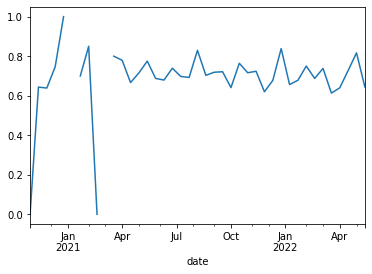

In [25]:
categories = []

for inspection in inspections:
    categories.append(
        {
            "date": pd.Timestamp(inspection["results"]["date"]),
            **{
                detail["property"]: int(detail["achievedPoints"]) / int(detail["possiblePoints"])
                for detail in inspection["details"]
            },
        }
    )

df = pd.DataFrame(categories)
df.set_index('date', inplace=True)
# df.sort_index().head()
df["Einhaltung LM-rechtlicher Bestimmungen"].resample("2w").mean().plot()


## Follow-up checks

In [37]:
follow_up_results = set()

for inspection in inspections:
    for follow_up in inspection["followUps"]:
        follow_up_results.add(follow_up["result"])

print(follow_up_results)


ratings = (
    (78, "sehr gut"),
    (60, "gut"),
    (39, "zufriedenstellend"),
    (21, "ausreichend"),
    (0, "nicht ausreichend")
)
rating_categories = [rating[1] for rating in ratings]

results = defaultdict(lambda: defaultdict(lambda: 0))

for inspection in inspections:
    conclusion = inspection["results"]["conclusion"]
    for follow_up in inspection["followUps"]:
        follow_up_result = follow_up["result"]
        results[conclusion][follow_up_result] += 1
        break

print(results)
return

df = pd.DataFrame(results, index=rating_categories)
#df.set_index(rating_categories, inplace=True)
df.head()



{'Mängel teilweise abgestellt', 'Verstoß mit Maßnahme', 'Verstoß', 'offen / in Arbeit', 'Mängel vollständig abgestellt', 'Mängel nicht abgestellt', 'Mängel überwiegend abgestellt'}
defaultdict(<function <lambda> at 0x7f064dfa5d80>, {'gut': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f064f7a5e10>, {'Mängel teilweise abgestellt': 8, 'Mängel überwiegend abgestellt': 9, 'Mängel vollständig abgestellt': 10}), 'nicht ausreichend': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f064f7a5ea0>, {'Mängel teilweise abgestellt': 37, 'Mängel vollständig abgestellt': 2, 'Mängel überwiegend abgestellt': 31, 'Mängel nicht abgestellt': 9, 'offen / in Arbeit': 1, 'Verstoß': 1}), 'ausreichend': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f064f7a5f30>, {'Mängel teilweise abgestellt': 37, 'Mängel überwiegend abgestellt': 43, 'Verstoß mit Maßnahme': 2, 'Mängel nicht abgestellt': 5, 'Mängel vollständig abgestellt': 4}), 'zufriedenstellend': defaultdict(<function <lambda>.<locals>

SyntaxError: 'return' outside function (1967288335.py, line 29)